# Importing Libraries

In [1]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder, FunctionTransformer, MinMaxScaler, StandardScaler, MaxAbsScaler, MultiLabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
from sklearn.feature_selection import SelectKBest, chi2
from scipy.stats import loguniform, randint, uniform
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import sklearn.metrics as skm
import seaborn as sns
import pandas as pd
import numpy as np
import re

# Reading the Data

In [2]:
train = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv')
test = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv')
movies = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv')

# Exploring the Data

## Train data

#### Let's start by exploring the train dataset. We'll start by checking the features and it's type in teh train dataset.

In [3]:
print("The columns in the train dataset are",train.columns.tolist())
print("The shape of the test dataset is",train.shape)

The columns in the train dataset are ['movieid', 'reviewerName', 'isFrequentReviewer', 'reviewText', 'sentiment']
The shape of the test dataset is (162758, 5)


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162758 entries, 0 to 162757
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   movieid             162758 non-null  object
 1   reviewerName        162758 non-null  object
 2   isFrequentReviewer  162758 non-null  bool  
 3   reviewText          156311 non-null  object
 4   sentiment           162758 non-null  object
dtypes: bool(1), object(4)
memory usage: 5.1+ MB


#### It is visible that there are no many numerical features in the train dataset. Therefore, we have to apply some type of encoding on the features we will use to train our model.

#### Now let's check for the missing values in the train data.

In [5]:
train.isna().mean()

movieid               0.000000
reviewerName          0.000000
isFrequentReviewer    0.000000
reviewText            0.039611
sentiment             0.000000
dtype: float64

#### Here, we see that the train dataset has very few missing values.
#### The only column with missing values here is 'reviewText' and even that is below the threshold of 0.05%. As a rule of thumb, it is an accepted practice to drop columns with missing values if they constitute less than 0.05% of the data.
#### However, we will instead be impputing the null values in this column with empty string instead because we do not have the option of dropping the null values from the test data.

#### Now let's try to plot some graphs with the features.

Text(0.5, 1.0, 'Count of Frequent Reviewers')

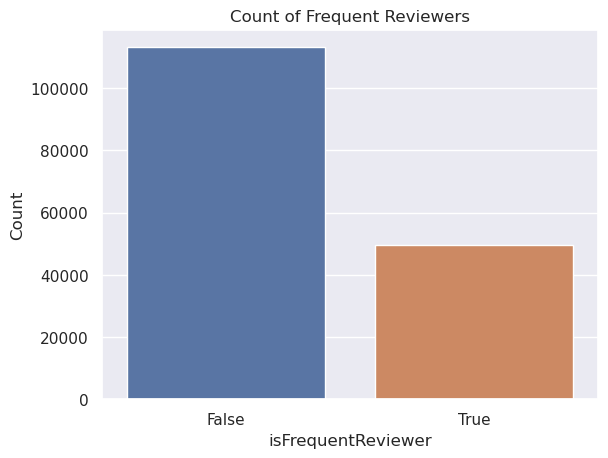

In [6]:
sns.set(style="darkgrid")

sns.countplot(x='isFrequentReviewer', data=train)
plt.xlabel('isFrequentReviewer')
plt.ylabel('Count')
plt.title('Count of Frequent Reviewers')

#### We can derive from this countplot that the number of reviewers who are not frequent outweigh the number of frequent reviewers by a good margin.

Text(0.5, 1.0, 'Sentiment on movies')

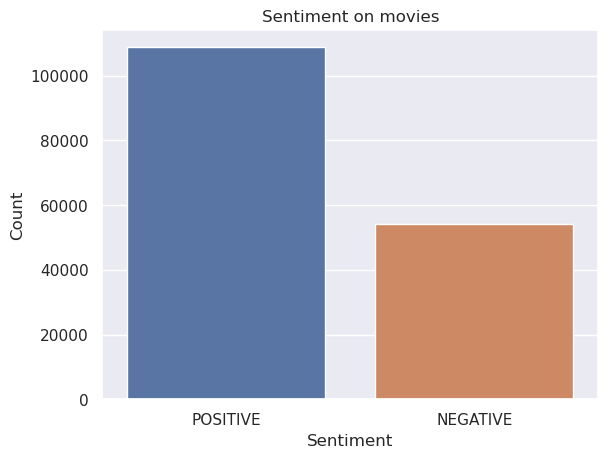

In [7]:
sns.set(style="darkgrid")

sns.countplot(x='sentiment', data=train)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment on movies')

#### It is visible that there are more Positive reviews on the movies as opposed to the negative review. This plot resembles the plot that we visualized earlier using the 'isFrequentReviewer' column. It can be a possible hypothesis that the non-frequent reviewers are more likely to give a positive review to a movie as opposed to frequent reviewers. However, we are yet to properly explore and analyze the data so this is not something we should let cloud any future insights that may be drawn from the data.

#### Let's try to visualize the top 50 words in 'reviewText' column.

In [8]:
corpus = train['reviewText'].astype(str).fillna('')
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
counts = np.sum(X.toarray(), axis=0)

words = vectorizer.get_feature_names_out()

count_dict = {}
for i in range(len(counts)):
    count_dict[words[i]] = counts[i]

count_dict = {k:v for k, v in sorted(count_dict.items(), key=lambda item: item[1], reverse=True)}


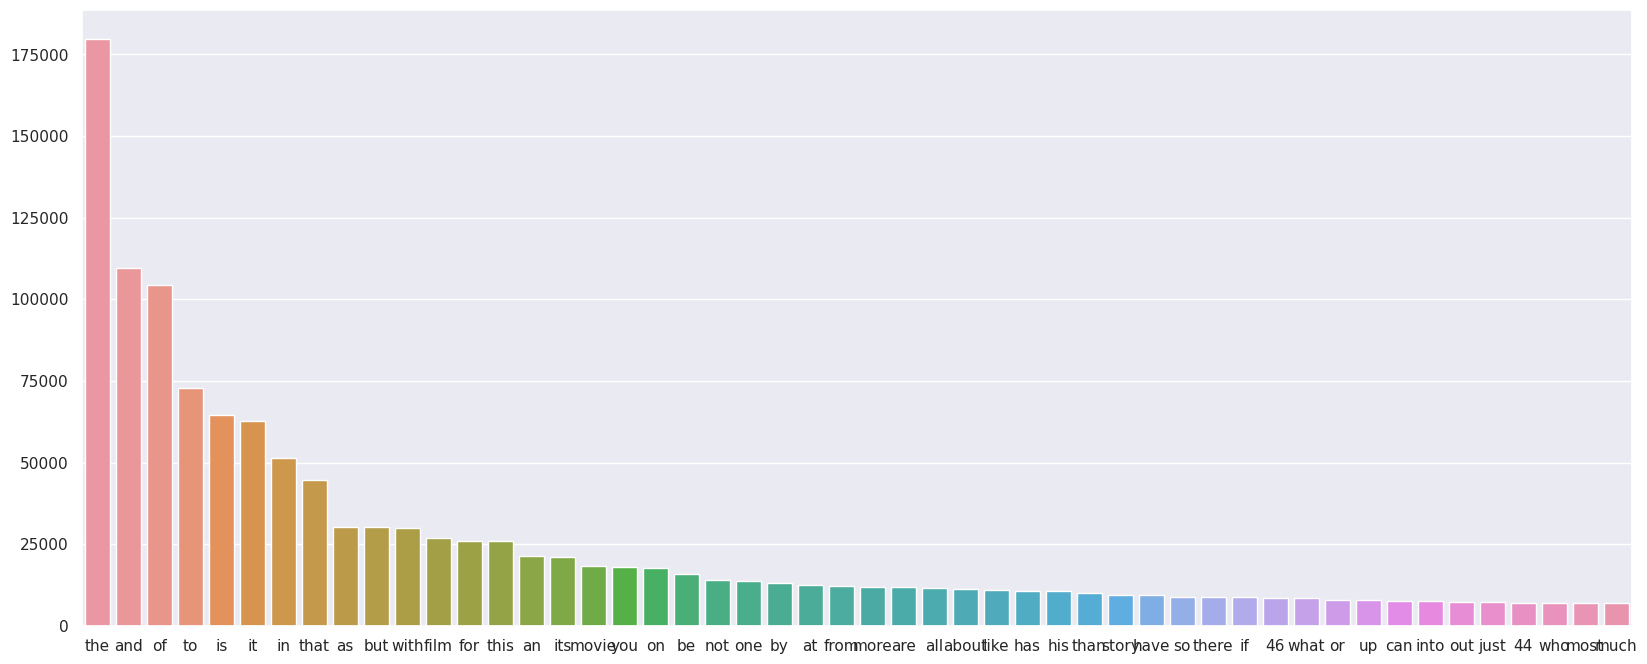

In [9]:
plt.figure(figsize=(20,8))
sns.barplot(x=list(count_dict.keys())[:50],y=list(count_dict.values())[:50])
plt.show()

#### From the above plot, it is very evident that there are a lot of stop words like 'the', 'it','its','in','and' etc. We will try to remove as many of these stopwords as possible in the 'reviewText' column as they provide no meaningful information and we can reduce the number of unncessary features by doint this as well.

#### We shall now move on to explore the movies dataset.

## Movies 

#### First, Let's see what are the feature in the movies dataset and what type of features are they. 

In [10]:
print("The columns in the movies dataset are",movies.columns.tolist())
print("The shape of the movies dataset is",movies.shape)

The columns in the movies dataset are ['movieid', 'title', 'audienceScore', 'rating', 'ratingContents', 'releaseDateTheaters', 'releaseDateStreaming', 'runtimeMinutes', 'genre', 'originalLanguage', 'director', 'boxOffice', 'distributor', 'soundType']
The shape of the movies dataset is (143258, 14)


In [11]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143258 entries, 0 to 143257
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   movieid               143258 non-null  object 
 1   title                 143258 non-null  object 
 2   audienceScore         73248 non-null   float64
 3   rating                13991 non-null   object 
 4   ratingContents        13991 non-null   object 
 5   releaseDateTheaters   30773 non-null   object 
 6   releaseDateStreaming  79420 non-null   object 
 7   runtimeMinutes        129431 non-null  float64
 8   genre                 132175 non-null  object 
 9   originalLanguage      129400 non-null  object 
 10  director              143258 non-null  object 
 11  boxOffice             14743 non-null   object 
 12  distributor           23005 non-null   object 
 13  soundType             15917 non-null   object 
dtypes: float64(2), object(12)
memory usage: 15.3+ MB


In [12]:
movies.isna().mean()

movieid                 0.000000
title                   0.000000
audienceScore           0.488699
rating                  0.902337
ratingContents          0.902337
releaseDateTheaters     0.785192
releaseDateStreaming    0.445616
runtimeMinutes          0.096518
genre                   0.077364
originalLanguage        0.096735
director                0.000000
boxOffice               0.897088
distributor             0.839416
soundType               0.888893
dtype: float64

#### There are a lot of features in the movies dataset. However, we can see from the information being displayed above that there are also a lot of missing values in these columns. Some of them can be promptly dealt with using Imputation techniques but there are also columns such as 'rating', 'ratingContents' etc. where the no. of missing values exceed more than 90% of the dataset. Such columns shall not be considered as training features for the model as the data that is available might not be a representative sample of the overall population. This can lead to biased or skewed distributions and impact the performance of our model.

In [13]:
movies[movies.duplicated()]

,movieid,title,audienceScore,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,boxOffice,distributor,soundType
1126,escape_the_terminator_tyler_durden_astonish,Escape The Terminator Tyler Durden Astonish,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Joseph Brooks,NaN,NaN,NaN
3772,supreme_indiana_jones,Supreme Indiana Jones,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Augusta Daniel,NaN,NaN,NaN
5048,escape_the_terminator_tyler_durden_astonish,Escape The Terminator Tyler Durden Astonish,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Joseph Brooks,NaN,NaN,NaN
7364,escape_the_terminator_tyler_durden_astonish,Escape The Terminator Tyler Durden Astonish,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Joseph Brooks,NaN,NaN,NaN
8012,holly_golightly_enthralling,Holly Golightly Enthralling,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Augusta Daniel,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140598,cosmic_jack_torrance_ellis_redding_indiana_jones,Cosmic Jack Torrance Ellis Redding Indiana Jones,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Augusta Daniel,NaN,NaN,NaN
140654,the_bride_hannibal_lecter_enigma_black_widow,The Bride Hannibal Lecter Enigma Black Widow,NaN,NaN,NaN,NaN,NaN,89.0,Drama,English,Raul Glover,NaN,NaN,NaN
141470,wolverine_tony_montana_wolverine,Wolverine Tony Montana Wolverine,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Augusta Daniel,NaN,NaN,NaN
142468,escape_the_terminator_tyler_durden_astonish,Escape The Terminator Tyler Durden Astonish,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Joseph Brooks,NaN,NaN,NaN


#### Taking a quick look at the data we can see there are a lot of missing values as well as many duplicates as well. 
#### We will drop the duplicate values before merging the relevant features with the train and test set.

#### Let's try to plot some visualizations for the featres in movies data as well

Text(0.5, 1.0, 'Audience Score')

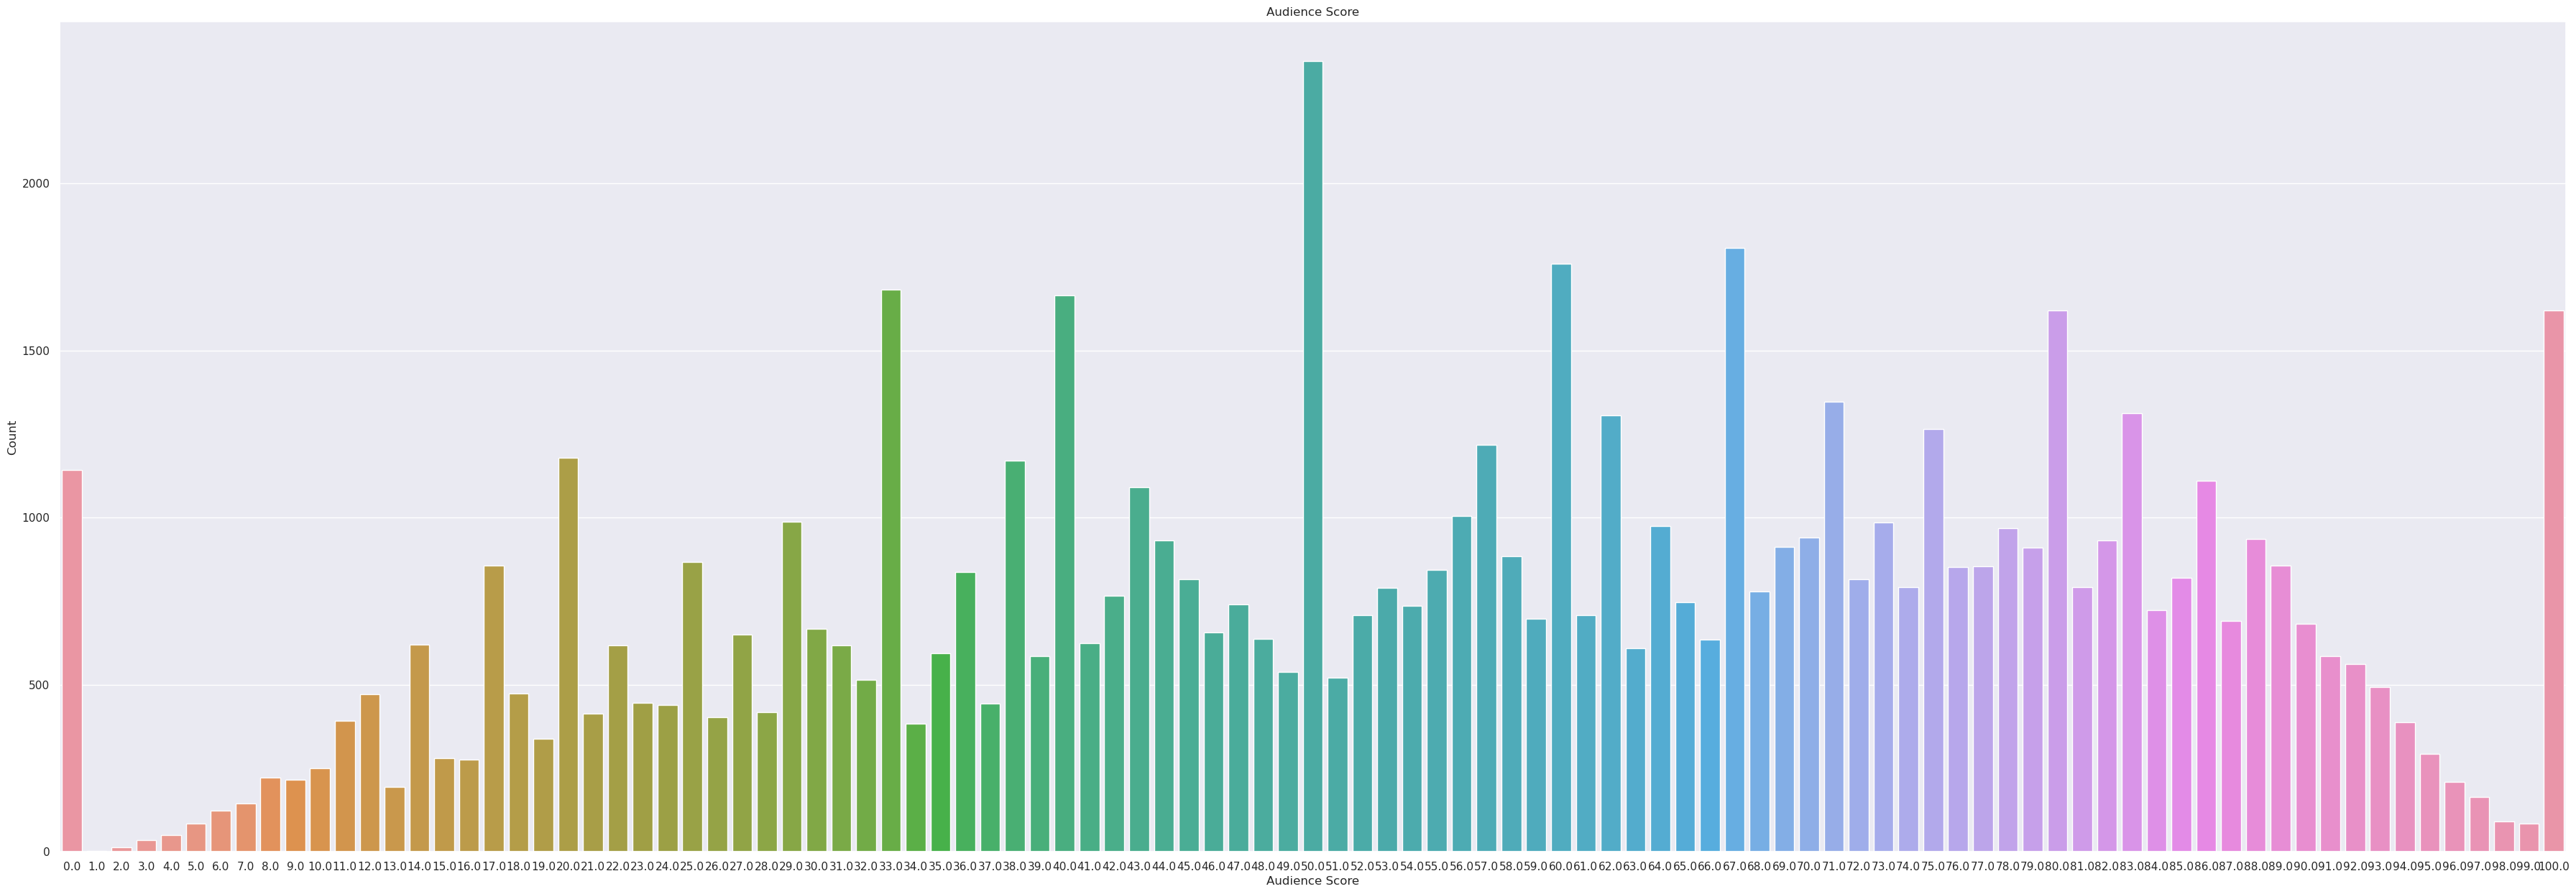

In [14]:
plt.figure(figsize=(45,15))
sns.set(style="darkgrid")
# palette = sns.color_palette("viridis")
sns.countplot(x='audienceScore', data=movies)

plt.xlabel('Audience Score')
plt.ylabel('Count')
plt.title('Audience Score')

Text(0.5, 1.0, 'Audience Score')

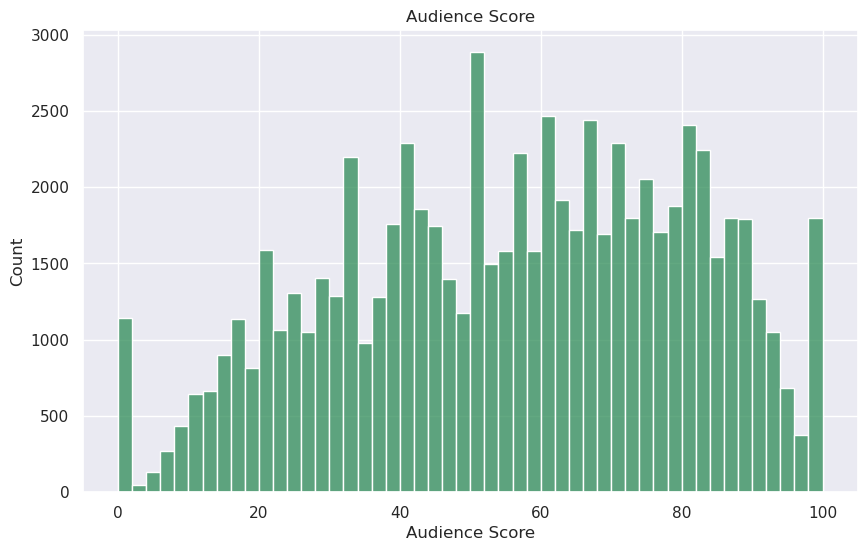

In [15]:
plt.figure(figsize=(10,6))
sns.set(style="darkgrid")
sns.histplot(x='audienceScore', data=movies, bins=50, color='seagreen')
plt.xlabel('Audience Score')
plt.ylabel('Count')
plt.title('Audience Score')

#### Here, we can see the distribution for the Audience Scores. There are different scores with different counts. One thing to notice here is that there are quite a number fo movies with 0 score and also very few movies get the score between 90.0 - 99.0 but there are many movies which have 100.0 score.

#### Let's check the relationship between the two numerical columns of the movies dataset.

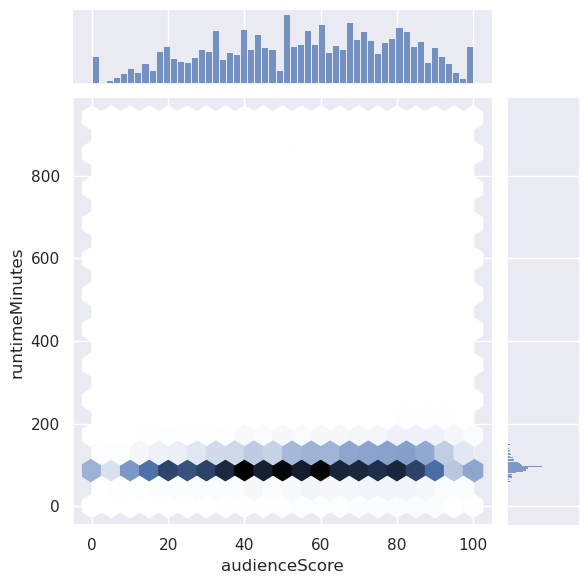

In [16]:
sns.jointplot(x = 'audienceScore', y = 'runtimeMinutes', data = movies, kind = 'hex', gridsize = 20)

#### The jointplot shows that there isn't a strong relationship between the features 'audienceScore' and 'runtimeMinutes'.|

Text(0.5, 1.0, 'Runtime of movies')

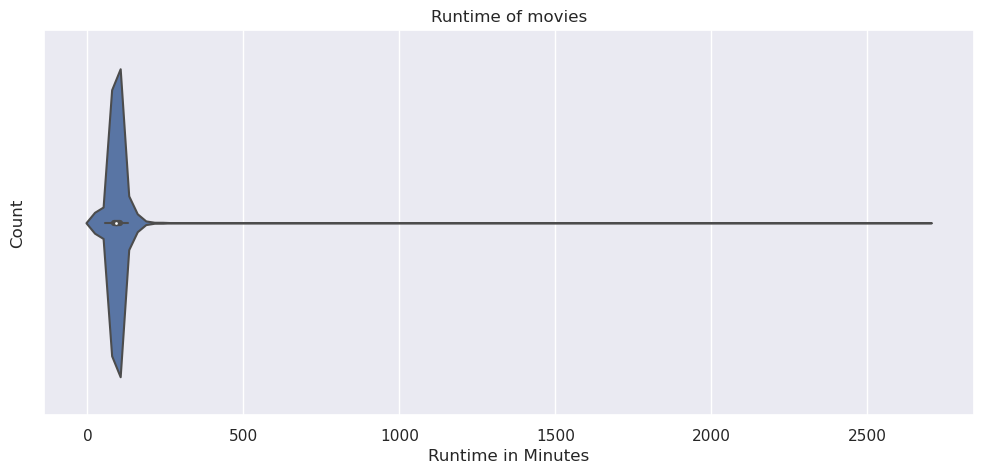

In [17]:
plt.figure(figsize=(12,5))
sns.set(style="darkgrid")

sns.violinplot(x='runtimeMinutes', data=movies)
plt.xlabel('Runtime in Minutes')
plt.ylabel('Count')
plt.title('Runtime of movies')

#### The "runtimeMinutes" column has quite a lot of outliers as we can see on this violinplot. This makes it harder to see any patterns in the data. Dea;ling with outliers is an important step of data preprocessing as outlier detection is a crucial data preprocessing step to improve data quality, ensure model accuracy, and maintain statistical assumptions. Removing or handling outliers enhances data interpretation, model robustness, and performance. 

#### Since we have noticed the outlliers in this column, let's check for outliers in other numerical columns of the movies dataset as well.

<Axes: xlabel='audienceScore'>

<Figure size 1600x500 with 0 Axes>

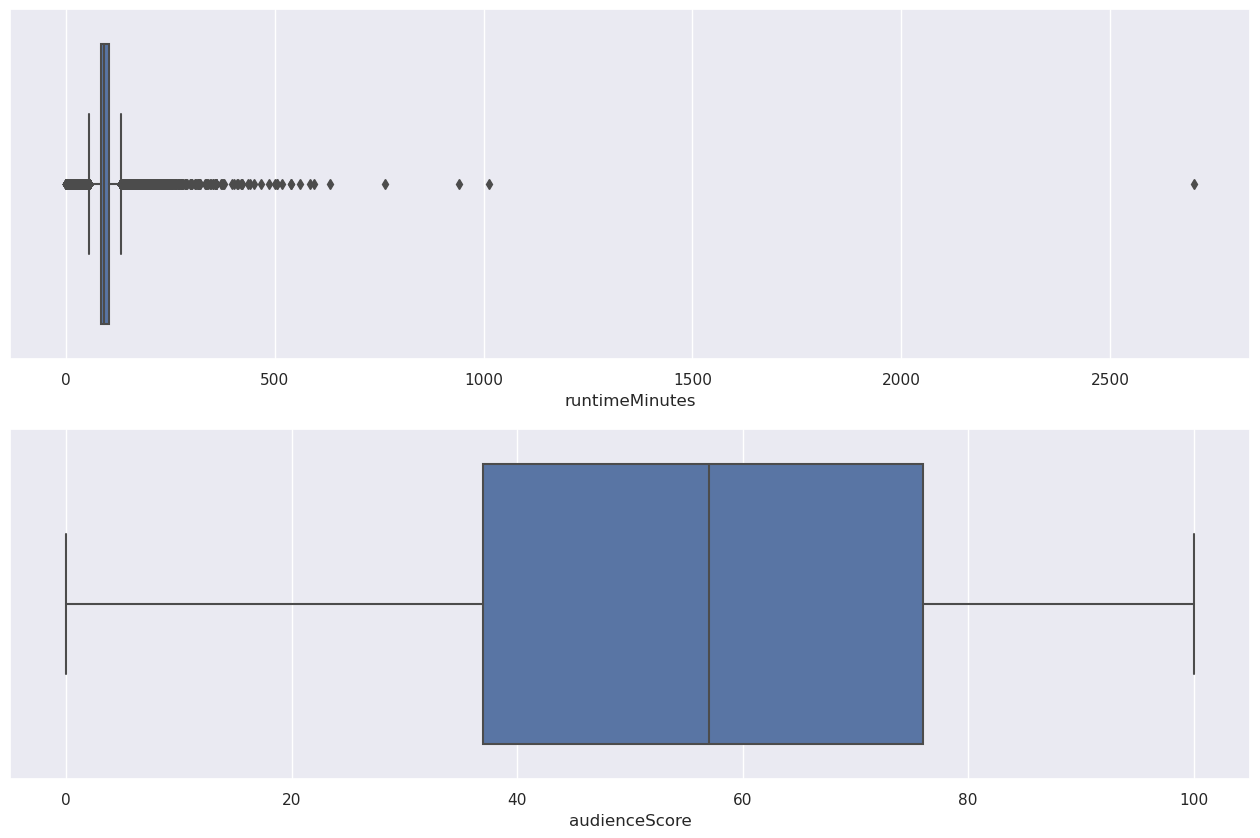

In [18]:
plt.figure(figsize=(16,5))
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 10), sharey=True)

sns.set(style="darkgrid")

sns.boxplot(x='runtimeMinutes', data=movies, ax=axes[0])

sns.boxplot(x='audienceScore', data=movies, ax=axes[1])


#### Features with many outliers are unsuitable for model training due to their influence on model performance, distorted relationships, and potential overfitting. Outliers violate assumptions, hinder interpretability, and challenge data normalization. Options include outlier removal, transformations, and using outlier-resistant models, while careful consideration and validation are essential.
#### And the above plot makes it clear that 'runtimeMinutes' is not a suitable column for training our model. The joinplot that we made earlier can be an assurance that we're not missing out on any important input by dropping the 'runtimeMinutes' column.

#### Additionally, we will be dropping the columns 'rating', 'ratingContents', 'releaseDateTheaters', 'genre', 'originalLanguage', , 'boxOffice', 'distributor', 'soundType' because they have more than 50% missing values. 
#### The columns 'releaseDateStreaming','genre' and 'director' are also being dropped as they do not seem relevant to our purpose to predicting sentiment of ReviewText.

#### Let's check the test dataset now

## Test

In [19]:
print("The columns in the train dataset are",test.columns.tolist())
print("The shape of the test dataset is",test.shape)

The columns in the train dataset are ['movieid', 'reviewerName', 'isTopCritic', 'reviewText']
The shape of the test dataset is (55315, 4)


In [20]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55315 entries, 0 to 55314
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   movieid       55315 non-null  object
 1   reviewerName  55315 non-null  object
 2   isTopCritic   55315 non-null  bool  
 3   reviewText    52805 non-null  object
dtypes: bool(1), object(3)
memory usage: 1.3+ MB


#### We can see here that just like the train dataset, this dataset also has missing values only in the 'reviewText' column. We will deal with this in the same manner that we will be dealing with the missing values in the train dataset.
#### It should also be mentioned that we will assume the "isTopCritic" column to be the same as the "isFrequentReviewer" in the train dataset.

In [21]:
test.rename(columns={'isTopCritic':'isFrequentReviewer'},inplace=True)

# Data Preprocesing

### Now, we shall preprocess the data and get it ready in order to train the model on it. 
### We will start by selecting the features we need from the movies dataset and drop the duplicate values.
### Then we will proceed to merge them with the train and test set. Following that, we will apply the necessary encoding and Imputation techniques to rid the data of any discrepancies. Lastly, we shall use some techniques to clean the text columns and get the final data prepared to train our models on.

### Selecting relevant features from Movies dataset

In [22]:
movies.drop(columns=['rating',
 'ratingContents',
 'releaseDateTheaters',
 'boxOffice',
 'distributor',
 'soundType',
 'releaseDateStreaming',
 'director',
 'runtimeMinutes',
 'originalLanguage'], axis=1, inplace=True)
movies.drop_duplicates(subset=['movieid'], keep='last', inplace=True)
movies.head(5)

,movieid,title,audienceScore,genre
0,han_solo_heroic_myth_wonder_woman,Han Solo Heroic Myth Wonder Woman,50.0,"Comedy, Horror, Sci-fi"
1,voyage_tyler_durden_han_solo_stardust,Voyage Tyler Durden Han Solo Stardust,NaN,Drama
2,norman_bates_ferris_bueller_hermione_granger_v...,Norman Bates Ferris Bueller Hermione Granger V...,43.0,Drama
3,elegant_hermione_granger,Elegant Hermione Granger,60.0,"Action, Mystery & thriller"
6,rocky_balboa_elegant_jack_sparrow,Rocky Balboa Elegant Jack Sparrow,55.0,Comedy


### Merging the train and Test datasets with the movies data

In [23]:
merged_train = pd.merge(train, movies, on='movieid', how='left')
merged_test = pd.merge(test, movies, on='movieid', how='left')
merged_train.drop(['reviewerName','movieid'],axis=1,inplace=True)
merged_test.drop(['reviewerName','movieid'],axis=1,inplace=True)

### Applying Imputations 

#### Replacing the null values in the data with empty strings.

In [24]:
merged_train['reviewText']= merged_train['reviewText'].astype(str).fillna('')
merged_test['reviewText'] = merged_test['reviewText'].astype(str).fillna('')

In [25]:
merged_train.isna().sum()

isFrequentReviewer        0
reviewText                0
sentiment                 0
title                     0
audienceScore         11710
genre                  2378
dtype: int64

In [26]:
imputer = SimpleImputer(strategy='mean')
merged_train[['audienceScore']] = imputer.fit_transform(merged_train[['audienceScore']])
merged_test[['audienceScore']] = imputer.fit_transform(merged_test[['audienceScore']])

In [27]:
imputer = SimpleImputer(strategy='most_frequent')
merged_train[['genre']] = imputer.fit_transform(merged_train[['genre']])
merged_test[['genre']] = imputer.fit_transform(merged_test[['genre']])

In [28]:
# getting unique Genres
merged_train['genre'] = merged_train['genre'].str.split(', ')
merged_test['genre'] = merged_test['genre'].str.split(', ')
unique_genres_train = set()
unique_genres_test = set()
for genres_list in merged_train['genre']:
    unique_genres_train.update(genres_list)
for genres_list in merged_test['genre']:
    unique_genres_test.update(genres_list)

In [29]:
# Iterate through each unique genre
for i in unique_genres_train:
    merged_train[i] = merged_train['genre'].apply(lambda x: 1 if i in x else 0)
for i in unique_genres_test:
    merged_test[i] = merged_test['genre'].apply(lambda x: 1 if i in x else 0)

In [30]:
merged_train.isna().sum()

isFrequentReviewer      0
reviewText              0
sentiment               0
title                   0
audienceScore           0
genre                   0
Comedy                  0
Lgbtq+                  0
Holiday                 0
Animation               0
Horror                  0
Nature                  0
History                 0
Health & wellness       0
Action                  0
Sci-fi                  0
Short                   0
Kids & family           0
Variety                 0
Music                   0
Other                   0
Stand-up                0
Crime                   0
Biography               0
Fantasy                 0
Sports & fitness        0
Gay & lesbian           0
Sports                  0
Western                 0
Foreign                 0
Documentary             0
Drama                   0
War                     0
Romance                 0
Mystery & thriller      0
Anime                   0
Adventure               0
Musical                 0
News        

In [31]:
merged_test.isna().sum()

isFrequentReviewer      0
reviewText              0
title                   0
audienceScore           0
genre                   0
Comedy                  0
Lgbtq+                  0
Holiday                 0
Animation               0
Horror                  0
Nature                  0
History                 0
Health & wellness       0
Action                  0
Sci-fi                  0
Short                   0
Kids & family           0
Variety                 0
Music                   0
Other                   0
Stand-up                0
Crime                   0
Biography               0
Fantasy                 0
Sports & fitness        0
Gay & lesbian           0
Sports                  0
Western                 0
Foreign                 0
Documentary             0
Drama                   0
War                     0
Romance                 0
Mystery & thriller      0
Anime                   0
Adventure               0
Musical                 0
News                    0
Faith & spir

#### With this, we have taken care of all the null values in our train and test set.

In [32]:
merged_test.head()

,isFrequentReviewer,reviewText,title,audienceScore,genre,Comedy,Lgbtq+,Holiday,Animation,Horror,...,Documentary,Drama,War,Romance,Mystery & thriller,Anime,Adventure,Musical,News,Faith & spirituality
0,False,Green slowly cranks up the dread with style an...,Legend Marty McFly Oracle,57.000000,"[Holiday, Horror, Mystery & thriller]",0,0,1,0,1,...,0,0,0,0,1,0,0,0,0,0
1,False,Philip Noyce's direction is elegant and unforc...,Terminator Katniss Everdeen Glimmer,86.000000,"[Drama, Adventure]",0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
2,False,It wouldn't do to say what path Maria ultimate...,James Bond Labyrinth Gollum,64.805684,[Drama],0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,False,Pig is not exactly the arthouse John Wick that...,V Quest Han Solo Wondrous,70.000000,[Comedy],1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,False,An imaginative no-budget musical of sorts abou...,Enigma Hulk Surreal Starlight,64.805684,"[Drama, Musical]",0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0


### Processing the Text columns

#### Since we are prohibited from using nltk or similar language processing libraries, we will make a custom list of stop words and then remove them from our dataset.

In [33]:
stop_words = [
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves',
    'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their',
    'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was',
    'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the',
    'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against',
    'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in',
    'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why',
    'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only',
    'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now','so', 'too',
    're', 'over', 'she', 'me', 'are', 'while', 'has', "she's", 'by', 'will', 'about', 'but', 'd', 'into', 'who', 's',
    'no', 'or', 'is', 'above', "mustn't", 'before', 'i', 'he', "mightn't", 'aren', 'now', 'my', 'why', "won't", 'a',
    'same', 'hers', 'up', 'wouldn', 'and', 'out', 'below', 'only', 'having', 'through', "doesn't", 'doesn', 'just', 
    'where', 'to', 'how', 'then', 'did', 'down', 'each', 'had', "you'd", 'herself', 'him', 'myself', 'hadn', 'you',
    'have', 'ma', "shan't", 'if', 'as', 'be', 'doing', 'being', 'an', 'than', 'didn', 'further', 'there', "isn't", 
    'themselves', 'any', 'more', "hasn't", 'from', "haven't", 'not', 've', 'all', 'we', 'again', 'at', 'am', 'such',
    'with', 'll', 'shouldn', 'of', 'do', 'against', 'both', "weren't", 'should', 'this', "aren't", 'shan', 'own', "couldn't", 
    "you're", 'o', 'during', "don't", 'what', 'haven', 'does', 'isn', 'which', 'don', 'theirs', 'in', "it's", 'for', 'was',
    'some', "you've", 'been', 'they', 'them', 'mustn', 'most', 'here', 'himself', "wasn't", 'that', 'their', 'can', "should've",
    "wouldn't", 'yourself', 'your', 'ours', 'after', 'on', 'few', 'y', 'off', 'until', 'it', 'her', 'our', 'weren', 'under', 'nor',
    'his', "didn't", "that'll", 'ain', 'needn', 'yourselves', 'the', 'because', 'very', 'whom', 'couldn', 'hasn', 'itself', "needn't",
    'yours', 'won', 'these', 'were', 'other', 'between', 't', 'when', 'ourselves', "shouldn't", 'its', 'those', "hadn't", 'mightn',
    'wasn', 'm', 'once', "you'll", 'the', 'this', 'it', 'its'
]

#### Defining functions that will be applied to the Text columns to clean it and prepare for Vectorization.

In [34]:
# Text cleaning
def clean_text(text):
    # Remove special characters and symbols
    text = text.lower()
    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', text)
    return cleaned_text


# Tokenization
def tokenize_text(text):
    tokens = text.split()
    return tokens


# Stop word removal
def remove_stopwords(tokens):
    stopword_list = set(stop_words)
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    return filtered_tokens


In [35]:
merged_train.columns

Index(['isFrequentReviewer', 'reviewText', 'sentiment', 'title',
       'audienceScore', 'genre', 'Comedy', 'Lgbtq+', 'Holiday', 'Animation',
       'Horror', 'Nature', 'History', 'Health & wellness', 'Action', 'Sci-fi',
       'Short', 'Kids & family', 'Variety', 'Music', 'Other', 'Stand-up',
       'Crime', 'Biography', 'Fantasy', 'Sports & fitness', 'Gay & lesbian',
       'Sports', 'Western', 'Foreign', 'Documentary', 'Drama', 'War',
       'Romance', 'Mystery & thriller', 'Anime', 'Adventure', 'Musical',
       'News', 'Faith & spirituality'],
      dtype='object')

### Applying the text cleaning functions to the text columns in the train and test sets.

In [36]:
merged_train['reviewText'] = merged_train['reviewText'].apply(clean_text)
merged_train['reviewText'] = merged_train['reviewText'].apply(tokenize_text)
merged_train['reviewText'] = merged_train['reviewText'].apply(remove_stopwords)
merged_train['reviewText'] = merged_train['reviewText'].apply(lambda x: ' '.join(x))

merged_train['title'] = merged_train['title'].apply(clean_text)
merged_train['title'] = merged_train['title'].apply(tokenize_text)
merged_train['title'] = merged_train['title'].apply(remove_stopwords)
merged_train['title'] = merged_train['title'].apply(lambda x: ' '.join(x))

In [37]:
merged_test['reviewText'] = merged_test['reviewText'].apply(clean_text)
merged_test['reviewText'] = merged_test['reviewText'].apply(tokenize_text)
merged_test['reviewText'] = merged_test['reviewText'].apply(remove_stopwords)
merged_test['reviewText'] = merged_test['reviewText'].apply(lambda x: ' '.join(x))


merged_test['title'] = merged_test['title'].apply(clean_text)
merged_test['title'] = merged_test['title'].apply(tokenize_text)
merged_test['title'] = merged_test['title'].apply(remove_stopwords)
merged_test['title'] = merged_test['title'].apply(lambda x: ' '.join(x))

In [38]:
merged_train.head()

,isFrequentReviewer,reviewText,sentiment,title,audienceScore,genre,Comedy,Lgbtq+,Holiday,Animation,...,Documentary,Drama,War,Romance,Mystery & thriller,Anime,Adventure,Musical,News,Faith & spirituality
0,False,henry selicks first movie since coraline fifth...,POSITIVE,marvelous pirate,65.0,"[Comedy, Animation, Adventure, Fantasy]",1,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1,False,cast reads like vogue oscar party guest list v...,NEGATIVE,tony montana frodo baggins v rocky balboa,47.0,"[Holiday, Romance, Comedy, Lgbtq+]",1,1,1,0,...,0,0,0,1,0,0,0,0,0,0
2,True,creed ii give us anything another slightly sup...,POSITIVE,darth vader katniss everdeen sorcerer donnie d...,80.0,[Drama],0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,False,know youre thinking limitless bradley cooper c...,POSITIVE,lara croft glimmer,47.0,"[Action, Mystery & thriller, Sci-fi]",0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,False,director fernando meirelles tells story urgenc...,POSITIVE,jason bourne surreal terminator indiana jones,97.0,"[Crime, Drama]",0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


#### Let's check for the top 30 words after processing the text data and removing stopwords.

In [39]:
corpus = merged_train['reviewText']
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
counts = np.sum(X.toarray(), axis=0)

words = vectorizer.get_feature_names_out()

count_dict = {}
for i in range(len(counts)):
    count_dict[words[i]] = counts[i]

count_dict = {k:v for k, v in sorted(count_dict.items(), key=lambda item: item[1], reverse=True)}


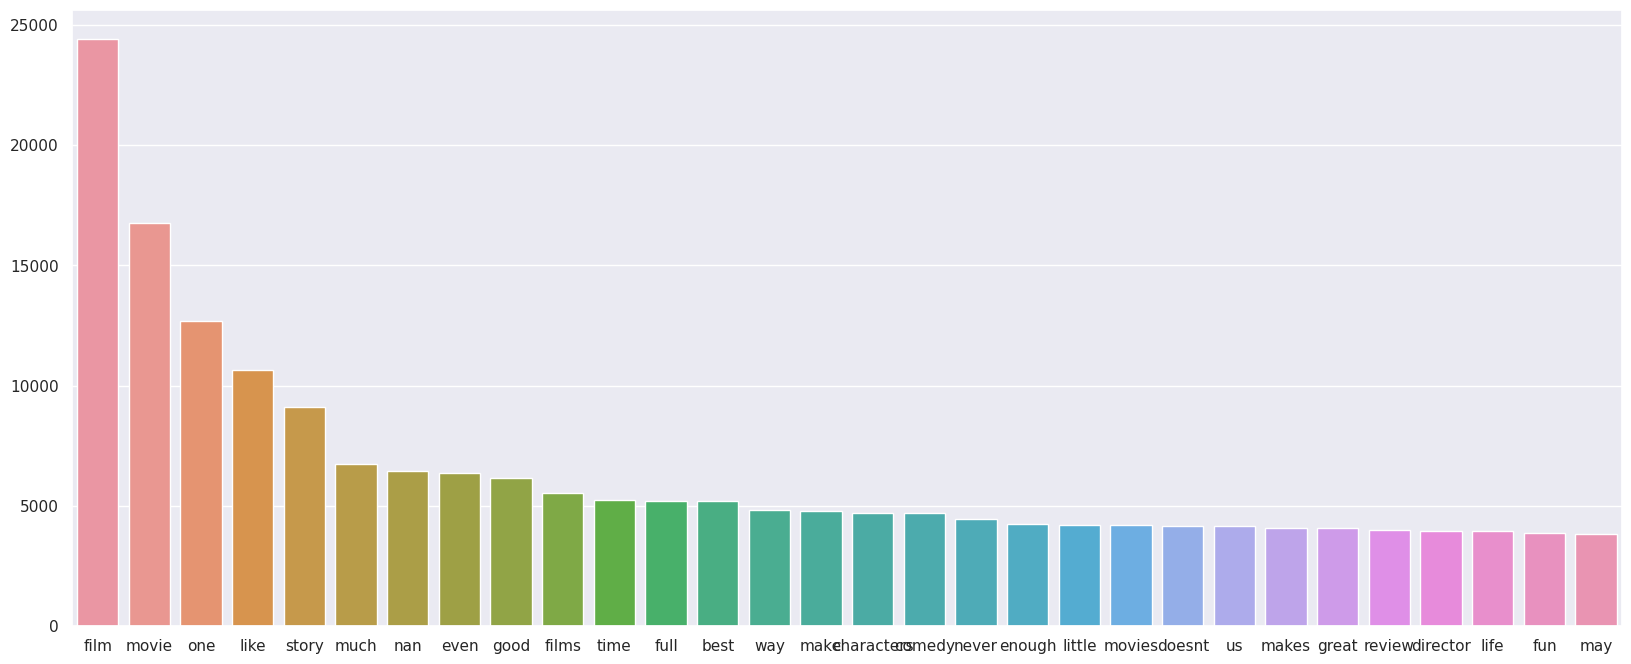

In [40]:
plt.figure(figsize=(20,8))
sns.barplot(x=list(count_dict.keys())[:30],y=list(count_dict.values())[:30])
plt.show()

#### As we can see, there are a lot less stop words as compared to the previous barplot. The irrelevant words such as 'the', 'it', 'its' etc. have been removed and now we have the relevant words in our dataset. 
#### However, it must be considered that because we are not using any Natural Language Processing libraries, the level of cleanliness of the text data will be very elss as compared to libraries such as nltk or wordnet since we are using a custom list of stopwords which only has a  limited number of stop words whereas the libraries contain a vast vocabulary for the same purpose.

In [41]:
X, y = merged_train.drop('sentiment', axis=1), merged_train['sentiment']

In [42]:
X.drop(columns="genre",inplace=True)

### Constructing a Column Transformer to apply Encoding and Scaling 

In [43]:
transformer = ColumnTransformer([
    ("title_tfidf",TfidfVectorizer(ngram_range=(1,3), min_df=0.00001), "title"),
    ("review_tfidf", TfidfVectorizer(ngram_range=(1,3), min_df=0.00001), 'reviewText'),
    ("frequentReviewer_encoder",OrdinalEncoder(),["isFrequentReviewer"]),
    ("score_scaler",MaxAbsScaler(), ["audienceScore"])
], remainder='passthrough', n_jobs=-1, verbose=True)
# feature_selector = SelectKBest(score_func=chi2, k=500000)

#### Let's check how our tranformed data looks like

In [44]:
feature_matrix = transformer.fit_transform(X)
feature_matrix.shape

(162758, 289725)

#### The transformed feature_matrix looks has a lot of features compared to when it was not transformed that's because most of our features were text columns and the words in those columns have been converted into features and thus resulting in a large number of features. 
#### We will be using Feature selection tehcniques to see which one gives us the best results.

# Logistic Regression Pipeline

In [45]:
logistic_pipe = Pipeline([("transformer", transformer),
#                           ("feature_selector", feature_selector),
                          ('LogReg', LogisticRegressionCV(random_state=10,max_iter=300, solver='liblinear', penalty='l2',fit_intercept=True,cv=5, n_jobs=-1))],
               verbose=True)

In [46]:
# param_dist = {
#     'LogReg__fit_intercept': [True, False],
#     'LogReg__class_weight': [None, 'balanced'],
#     'LogReg__penalty': ['l1', 'l2', 'elasticnet'],
#     'LogReg__tol': [1e-4, 1e-3, 1e-2]
    
# }
# random_search = RandomizedSearchCV(
#     logistic_pipe,
#     param_distributions=param_dist,
#     n_iter=10,      
#     n_jobs=-1,  
#     verbose=2  
# )
# random_search.fit(X, y)
# best_hyperparameters = random_search.best_params_
# best_model = random_search.best_estimator_
# print(best_hyperparameters, best_model)

In [47]:
logistic_pipe.fit(X,y)

[Pipeline] ....... (step 1 of 2) Processing transformer, total=  18.5s
[ColumnTransformer]  (3 of 5) Processing frequentReviewer_encoder, total=   0.0s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[ColumnTransformer] .. (2 of 5) Processing review_tfidf, total=  14.2s
[ColumnTransformer] .. (4 of 5) Processing score_scaler, total=   0.0s
[ColumnTransformer] ... (1 of 5) Processing title_tfidf, total=   4.3s
[ColumnTransformer] .. (2 of 5) Processing review_tfidf, total=  14.9s
[ColumnTransformer] .. (4 of 5) Processing score_scaler, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing LogReg, total=32.1min


Pipeline(steps=[('transformer',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('title_tfidf',
                                                  TfidfVectorizer(min_df=1e-05,
                                                                  ngram_range=(1,
                                                                               3)),
                                                  'title'),
                                                 ('review_tfidf',
                                                  TfidfVectorizer(min_df=1e-05,
                                                                  ngram_range=(1,
                                                                               3)),
                                                  'reviewText'),
                                                 ('frequentReviewer_encoder',
                                                  OrdinalEncoder(),
                                                  ['isFrequentReviewer']),
                                                 ('score_scaler',
                                                  MaxAbsScaler(),
                                                  ['audienceScore'])],
                                   verbose=True)),
                ('LogReg',
                 LogisticRegressionCV(cv=5, max_iter=300, n_jobs=-1,
                                      random_state=10, solver='liblinear'))],
         verbose=True)

In [48]:
train_pred_logistic = logistic_pipe.predict(X)


In [49]:
y_pred_logistic = logistic_pipe.predict(merged_test)

In [50]:
logistic_pipe.score(X,y) 

0.9310817287015077

In [51]:
print(skm.classification_report(y,train_pred_logistic))

              precision    recall  f1-score   support

    NEGATIVE       0.93      0.85      0.89     53997
    POSITIVE       0.93      0.97      0.95    108761

    accuracy                           0.93    162758
   macro avg       0.93      0.91      0.92    162758
weighted avg       0.93      0.93      0.93    162758



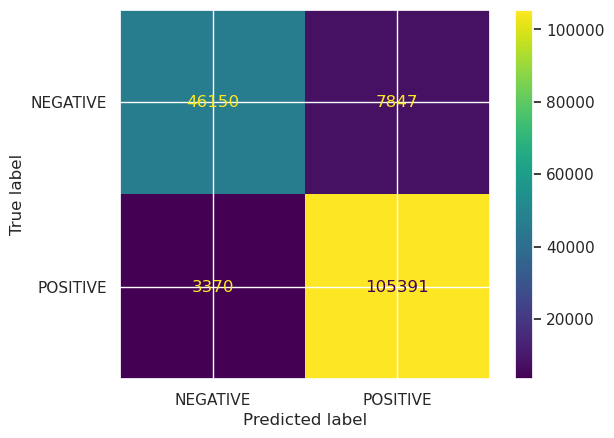

In [52]:
conf_mat = skm.confusion_matrix(y,train_pred_logistic)
disp = skm.ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=logistic_pipe[-1].classes_)
disp.plot()
plt.show()

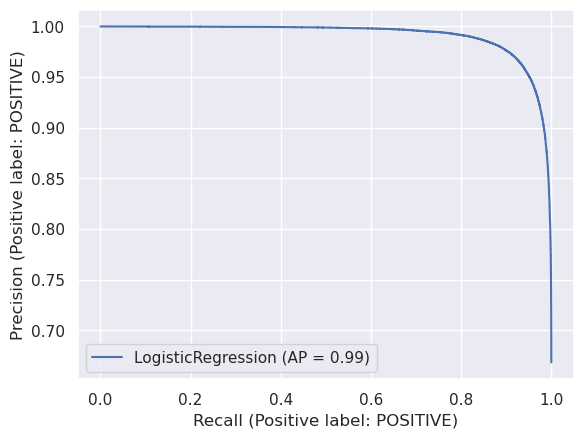

In [53]:
display_svc = skm.PrecisionRecallDisplay.from_estimator(
    logistic_pipe, X, y, name="LogisticRegression"
)

# SVM Pipeline

In [54]:
pipe_svc = Pipeline([("transformer", transformer),
#                      ("feature_selector", feature_selector),
                 ('Svm', LinearSVC(C=0.20584494295802447,class_weight='balanced',dual=False,max_iter=2000,penalty='l2',tol=0.0001))],
               verbose=True)

In [55]:
# param_grid = {
#     'Svm__C': uniform(loc=0, scale=10),  # Regularization parameter C for LinearSVC
#     'Svm__max_iter': [1000, 2000, 3000],  # Maximum number of iterations for LinearSVC
#     'Svm__dual': [True, False],  # Use dual or primal formulation for LinearSVC
#     'Svm__class_weight': [None, 'balanced'],
#     'Svm__tol': [1e-3, 1e-4, 1e-5],  # Tolerance for stopping criterion
#     'Svm__penalty': ['l1', 'l2'],  # Norm used in the penalty
#     'Svm__fit_intercept': [True, False] # Class weight for LinearSVC
# }
# random_search = RandomizedSearchCV(
#     pipe_svc,  # The pipeline
#     param_distributions=param_grid,  # The hyperparameter grid
#     n_iter=10,  # Number of random parameter combinations to try
#     scoring='accuracy',  # Use accuracy as the evaluation metric
#     n_jobs=-1,  # Use all available CPU cores for faster computation
#     cv=5,  # Cross-validation fold
#     random_state=42  # For reproducibility
# )


# random_search.fit(X,y)

# best_params = random_search.best_params_
# best_model = random_search.best_estimator_

# print(best_params)
# print(best_model)

In [56]:
pipe_svc.fit(X,y)

[Pipeline] ....... (step 1 of 2) Processing transformer, total=  19.2s
[Pipeline] ............... (step 2 of 2) Processing Svm, total=  46.7s


Pipeline(steps=[('transformer',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('title_tfidf',
                                                  TfidfVectorizer(min_df=1e-05,
                                                                  ngram_range=(1,
                                                                               3)),
                                                  'title'),
                                                 ('review_tfidf',
                                                  TfidfVectorizer(min_df=1e-05,
                                                                  ngram_range=(1,
                                                                               3)),
                                                  'reviewText'),
                                                 ('frequentReviewer_encoder',
                                                  OrdinalEncoder(),
                                                  ['isFrequentReviewer']),
                                                 ('score_scaler',
                                                  MaxAbsScaler(),
                                                  ['audienceScore'])],
                                   verbose=True)),
                ('Svm',
                 LinearSVC(C=0.20584494295802447, class_weight='balanced',
                           dual=False, max_iter=2000))],
         verbose=True)

In [57]:
train_pred_svc = pipe_svc.predict(X)
y_pred_svc = pipe_svc.predict(merged_test)

In [58]:
pipe_svc.score(X,y)

0.9229285196426597

In [59]:
print(skm.classification_report(y,train_pred_svc))

              precision    recall  f1-score   support

    NEGATIVE       0.84      0.94      0.89     53997
    POSITIVE       0.97      0.91      0.94    108761

    accuracy                           0.92    162758
   macro avg       0.91      0.93      0.92    162758
weighted avg       0.93      0.92      0.92    162758



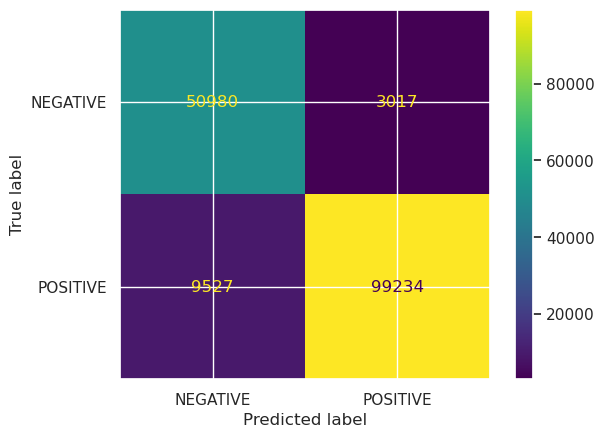

In [60]:
conf_mat = skm.confusion_matrix(y,train_pred_svc)
disp = skm.ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=pipe_svc[-1].classes_)
disp.plot()
plt.show()

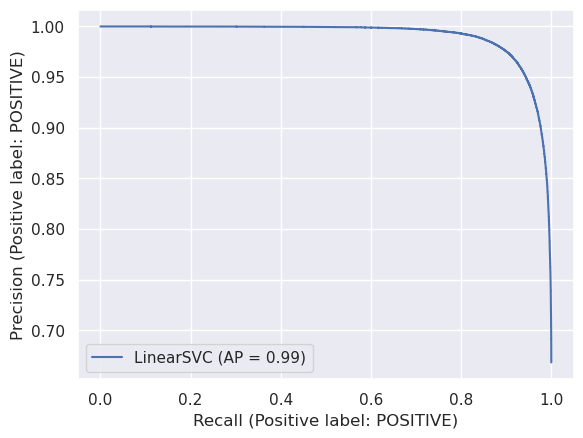

In [61]:
display_svc = skm.PrecisionRecallDisplay.from_estimator(
    pipe_svc, X, y, name="LinearSVC"
)

# Bagging Pipeline

In [62]:
pipe_bagging = Pipeline([("transformer", transformer),
#                         ("feature_selector", feature_selector),
                        ('Bagging', BaggingClassifier(estimator=LogisticRegression()))],
               verbose=True)

In [63]:
# param_dist = {
#     'Bagging__n_estimators': [10, 50, 100], 
#     'Bagging__max_samples': [0.5, 0.7, 0.9],  
#     'Bagging__max_features': [0.5, 0.7, 0.9],  
#     'Bagging__bootstrap': [True, False],  
#     'Bagging__bootstrap_features': [True, False]
# }

In [64]:
# # Create the RandomizedSearchCV object
# random_search = RandomizedSearchCV(
#     estimator=pipe_bagging,
#     param_distributions=param_dist,
#     n_iter=10, 
#     scoring='f1_micro',  
#     cv=5,  
#     verbose=2,  
#     n_jobs=-1,  
#     random_state=42  
# )

# random_search.fit(X, y)

# print("Best Parameters: ", random_search.best_params_)
# print("Best F1 Score: ", random_search.best_score_)

In [65]:
pipe_bagging.fit(X,y)

[Pipeline] ....... (step 1 of 2) Processing transformer, total=  19.5s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

[Pipeline] ........... (step 2 of 2) Processing Bagging, total= 3.8min


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('transformer',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('title_tfidf',
                                                  TfidfVectorizer(min_df=1e-05,
                                                                  ngram_range=(1,
                                                                               3)),
                                                  'title'),
                                                 ('review_tfidf',
                                                  TfidfVectorizer(min_df=1e-05,
                                                                  ngram_range=(1,
                                                                               3)),
                                                  'reviewText'),
                                                 ('frequentReviewer_encoder',
                                                  OrdinalEncoder(),
                                                  ['isFrequentReviewer']),
                                                 ('score_scaler',
                                                  MaxAbsScaler(),
                                                  ['audienceScore'])],
                                   verbose=True)),
                ('Bagging', BaggingClassifier(estimator=LogisticRegression()))],
         verbose=True)

In [66]:
train_pred_bagging = pipe_bagging.predict(X)
y_pred_bagging = pipe_bagging.predict(merged_test)

In [67]:
pipe_bagging.score(X,y)

0.8661755489745512

In [68]:
print(skm.classification_report(y,train_pred_bagging))

              precision    recall  f1-score   support

    NEGATIVE       0.86      0.72      0.78     53997
    POSITIVE       0.87      0.94      0.90    108761

    accuracy                           0.87    162758
   macro avg       0.86      0.83      0.84    162758
weighted avg       0.87      0.87      0.86    162758



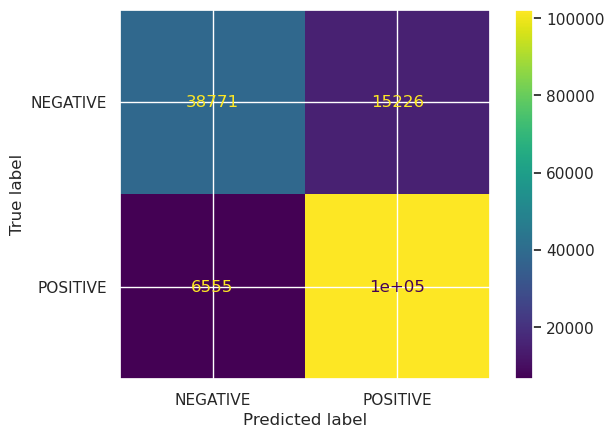

In [69]:
conf_mat = skm.confusion_matrix(y,train_pred_bagging)
disp = skm.ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=pipe_bagging[-1].classes_)
disp.plot()
plt.show()

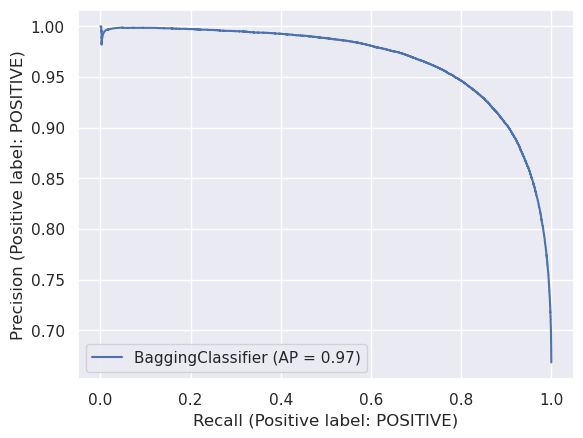

In [70]:
display_bagging= skm.PrecisionRecallDisplay.from_estimator(
    pipe_bagging, X, y, name="BaggingClassifier"
)

# Multi-Layer Perceptron Pipeline

In [71]:
# pipe_perceptron = Pipeline([("transformer", transformer),
#                  ('MLP', MLPClassifier(max_iter=20,random_state=1,hidden_layer_sizes=(20,20, 50)))],
#                verbose=True)

In [72]:
# pipe_perceptron.fit(X,y)

In [73]:
# train_pred_perceptron = pipe_perceptron.predict(X)
# y_pred_perceptron = pipe_perceptron.predict(merged_test)

In [74]:
# pipe_perceptron.score(X,y)

# Creating Submission file

In [75]:
submission_df = pd.DataFrame({'sentiment': y_pred_logistic})
submission_df.index.names = ['id']
submission_df.to_csv('submission.csv')

In [76]:
submission_df.shape

(55315, 1)

In [77]:
submission_df.head()

,sentiment
id,
0,POSITIVE
1,POSITIVE
2,POSITIVE
3,POSITIVE
4,POSITIVE
